# **Evaluation - Problem 1**
**Load the data**

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from tqdm import tqdm
import os
import sys
import json
from collections import Counter

# run another notebook to load the function compute_similarities() to compute the similarity scores for each standardroute-actual-route-pair
# this notebook also runs the notebook for data generation to load the function show_route() to visualize routes which is part of the similarity score functions
%run "functions_similarity_score_evaluation.ipynb"


# SELECT WHICH DATA TO LOAD
#20: for 20 sr and 100000 ar
#50: for 50 sr and 100000 ar
#100: for 100 sr and 100000 ar
appendix = str(20)

# load original standardroutes and actual routes
org_standardroutes = fun_load_file(path='../../data', name=str('standard' + appendix + '.json'))
org_actual_routes = fun_load_file(path='../../data', name=str('actual' + appendix + '.json'))

# load parameter dictionary (to have the same parameters for creating new actual routes)
parameter_dictionary = fun_load_file(path='../../data', name='parameter_dictionary.json')

# assign each value to its name in order to be able to use them as variables
for key, value in parameter_dictionary.items():
    if key == 'df_drivers_attributes': locals()[key] = pd.DataFrame(value) #turn dictionary back to DF
    else: locals()[key] = value

# load recommended standardroutes
rec_standardroutes = fun_load_file(path='../../results', name=str('recStandard' + appendix + '.json'))

print('Number of original standardroutes:', len(org_standardroutes))
print('Number of original actual routes:', len(org_actual_routes))
print('Number of recommended standardroutes:', len(rec_standardroutes))

Functions for data generation successfully loaded.
Functions for similarity score computations successfully loaded.
Number of original standardroutes: 20
Number of original actual routes: 100000
Number of recommended standardroutes: 18


In [2]:
#for i in rec_standardroutes: show_route(i)

# **A: View Recommended Standardroutes**
**View appearance of cities, products and quantitites in the recommended standardroutes**

In [3]:
def fun_counts(routes):

    # create lists to store all cities, products and quantities of the recommended standardroutes
    cities_sr = []
    products_sr = []
    quantities_sr = []

    # create lists to store the number of trips and products
    num_of_trips = []
    num_of_products = []

    for route in routes:
        # get all cities (starting city first, then all destinations)
        route_c = [route['route'][0]['from']]
        route_c += [i['to'] for i in route['route']]
        num_of_trips.append(len(route_c)-1)

        # get all products (list per trip, then combine lists)
        route_p = [list(i['merchandise'].keys()) for i in route['route']]
        for trip in route_p: num_of_products.append(len(trip))
        route_p = [item for list in route_p for item in list]

        # get all quantities (list per trip, then combine lists)
        route_q = [i['merchandise'].values() for i in route['route']]
        route_q = [item for list in route_q for item in list]
        
        # append lists of route to the lists of all standardroutes
        cities_sr += route_c
        products_sr += route_p
        quantities_sr += route_q
    
    # count the appearances of all values in every list
    city_counts = dict(Counter(cities_sr))
    product_counts = dict(Counter(products_sr))
    quantitiy_counts = dict(Counter(quantities_sr))
    num_of_trips_counts = dict(Counter(num_of_trips))
    num_of_products_counts = dict(Counter(num_of_products))

    return city_counts, product_counts, quantitiy_counts, num_of_trips_counts, num_of_products_counts

org_city_counts, org_product_counts, org_quantitiy_counts, org_num_of_trips_counts, org_num_of_products_counts = fun_counts(org_standardroutes)
rec_city_counts, rec_product_counts, rec_quantitiy_counts, rec_num_of_trips_counts, rec_num_of_products_counts = fun_counts(rec_standardroutes)

In [4]:
# compute the total number of trips and cities in original and recommended standardroutes
org_num_trips_sum = np.sum([key*org_num_of_trips_counts[key] for key in org_num_of_trips_counts.keys()])
rec_num_trips_sum = np.sum([key*rec_num_of_trips_counts[key] for key in rec_num_of_trips_counts.keys()])
org_num_cities_sum = org_num_trips_sum + len(org_standardroutes)
rec_num_cities_sum = rec_num_trips_sum + len(rec_standardroutes)

# compute the factor
factor = org_num_cities_sum / rec_num_cities_sum
print('factor:', factor)

# multiply all counts in the recommended standardroutes by the factor to get the same number of cities as in the original standardroutes
weighted_rec_city_counts = {i: rec_city_counts[i] * factor for i in rec_city_counts}

# check if number of cities in original and recommended standardroutes are equal now (to be able to compare them)
if (int(np.sum(list(weighted_rec_city_counts.values()))) == org_num_cities_sum):
    print('Number of cities in original and recommended standardroutes are equal now: {} cities'.format(org_num_cities_sum))

# select all cities that are liked or disliked by a driver
dislikes = list(driver_cities_dislikes.values())
dislikes = [i for j in dislikes for i in j]
likes = list(driver_cities_likes.values())
likes = [i for j in likes for i in j]
attribute_cities = likes + dislikes

# compute the percentage change in the count of all cities from original to recommended standardroutes
# select only the cities that are liked or disliked by a driver
city_pct_change = {i: (weighted_rec_city_counts[i] / org_city_counts[i]) - 1 for i in weighted_rec_city_counts.keys()}
city_pct_change = {city: city_pct_change[city] for city in attribute_cities}

factor: 1.525
Number of cities in original and recommended standardroutes are equal now: 122 cities


In [5]:
# compute the total number of products in original and recommended standardroutes
org_num_products_sum = np.sum([key*org_num_of_products_counts[key] for key in org_num_of_products_counts.keys()])
rec_num_products_sum = np.sum([key*rec_num_of_products_counts[key] for key in rec_num_of_products_counts.keys()])

# compute the factor
factor = org_num_products_sum / rec_num_products_sum
print('factor:', factor)

# multiply all counts in the recommended standardroutes by the factor to get the same number of products as in the original standardroutes
weighted_rec_product_counts = {i: rec_product_counts[i] * factor for i in rec_product_counts}

# check if number of products in original and recommended standardroutes are equal now (to be able to compare them)
if (int(np.sum(list(weighted_rec_product_counts.values()))) == org_num_products_sum):
    print('Number of products in original and recommended standardroutes are equal now: {} products'.format(org_num_products_sum))


# select all products that are liked or disliked by a driver
attribute_products = list(driver_products.values())
attribute_products = [i for j in attribute_products for i in j]

# compute the percentage change in the count of all products from original to recommended standardroutes
# select only the products that are liked or disliked by a driver
product_pct_change = {i: (weighted_rec_product_counts[i] / org_product_counts[i]) - 1 for i in weighted_rec_product_counts.keys()}
product_pct_change = {product: product_pct_change[product] for product in attribute_products}

factor: 1.4065040650406504
Number of products in original and recommended standardroutes are equal now: 519 products


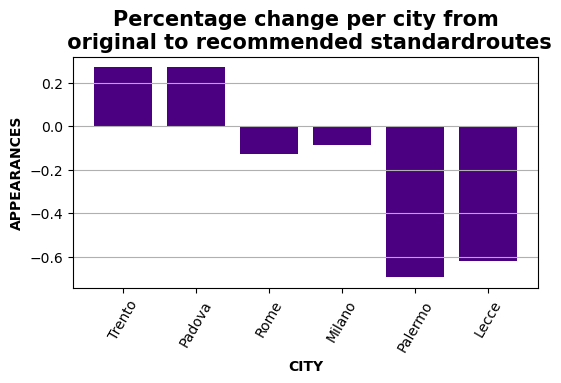

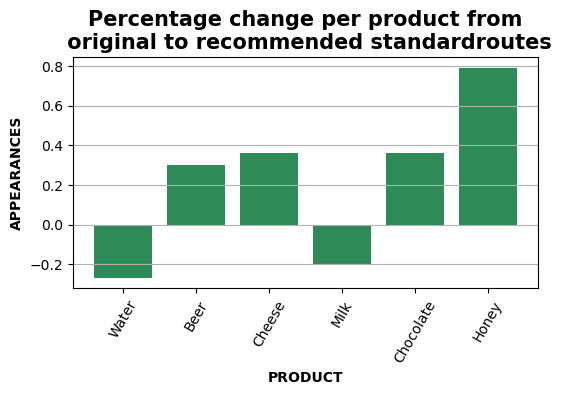

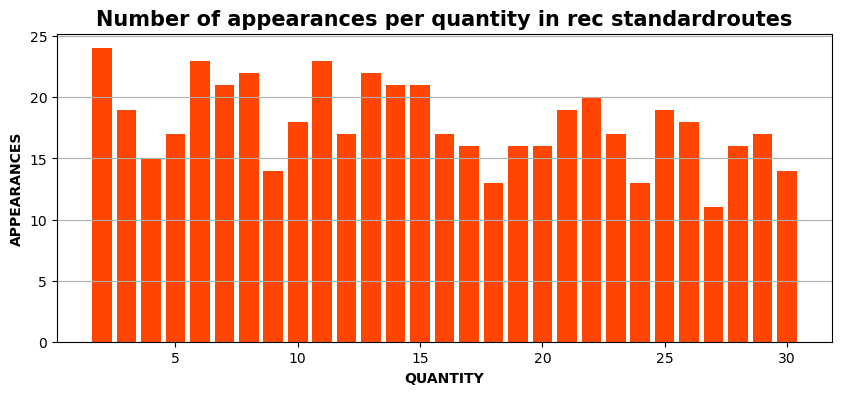

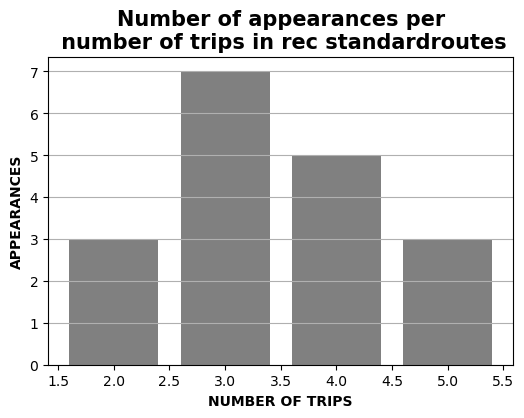

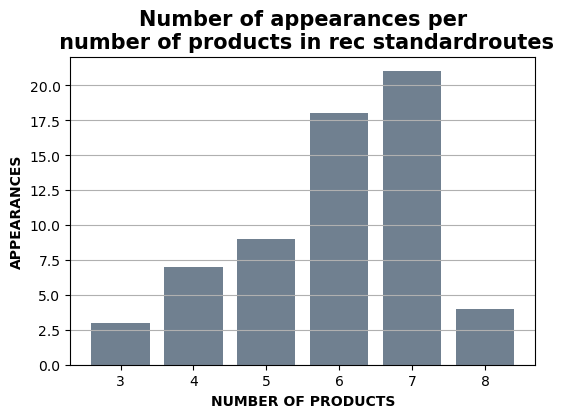

In [6]:
# function to plot the counts/pct changes
def fun_plot_appearances(name, counts, color, title, figsize=(6, 3)):

    # create barplot to view the number of appearances
    plt.figure(figsize=figsize)
    plt.bar(x=counts.keys(), height=counts.values(), color=color)

    # set title and axis name and add legend
    plt.title(title, fontsize=15, fontweight='bold')
    plt.ylabel('APPEARANCES', fontsize=10, fontweight='bold')
    plt.xlabel(name.upper(), fontsize=10, fontweight='bold')
    
    # edit axis ticks
    if isinstance(list(counts.keys())[0], str): plt.xticks(rotation=60)

    # grid lines
    plt.grid(True, axis='y')

    return plt.show()

# # execute function for a all count dicitonary
fun_plot_appearances('city', city_pct_change, 'indigo', title='Percentage change per city from\n original to recommended standardroutes')
fun_plot_appearances('product', product_pct_change, 'seagreen', title='Percentage change per product from\n original to recommended standardroutes')
fun_plot_appearances('quantity', org_quantitiy_counts, 'orangered', figsize=(10, 4), title='Number of appearances per quantity in rec standardroutes')
fun_plot_appearances('number of trips', rec_num_of_trips_counts, 'gray', figsize=(6, 4), title='Number of appearances per\n number of trips in rec standardroutes')
fun_plot_appearances('number of products', rec_num_of_products_counts, 'slategrey', figsize=(6, 4), title='Number of appearances per\n number of products in rec standardroutes')

### **B) Create the same amount of actual routes again with the recommended standardroutes**

In [7]:
# compute how many routes to generate
number_of_actual_routes = len(org_actual_routes)
jobs_per_route = int(number_of_actual_routes / len(rec_standardroutes))

# create new actual routes
rec_actual_routes = fun_aroutes(input_sr=rec_standardroutes, driver_given=False, prints=True, debug=False)

Processing:   0%|          | 0/18 [00:00<?, ?iteration/s]

Processing: 100%|██████████| 18/18 [01:41<00:00,  5.66s/iteration]


### **Compute similarity scores - for orginial standardroutes and recommended ones**

In [8]:
# compute similarity scores with original standardroutes
print('-------------------------Original standardroutes-------------------------')
org_scores = compute_similarites(input_sr=org_standardroutes, input_ar=org_actual_routes, prints=False)

# compute similarity scores with recommended standardroutes
print('------------------------Recommended standardroutes-----------------------')
rec_scores = compute_similarites(input_sr=rec_standardroutes, input_ar=rec_actual_routes, prints=False)

-------------------------Original standardroutes-------------------------


Processing: 100%|██████████| 100000/100000 [01:16<00:00, 1300.48iteration/s]



All scores successfully computed.
Mean similarity score: 0.6074
------------------------Recommended standardroutes-----------------------


Processing: 100%|██████████| 99990/99990 [00:56<00:00, 1764.73iteration/s]


All scores successfully computed.
Mean similarity score: 0.6645


### **Analyse the similarity scores**

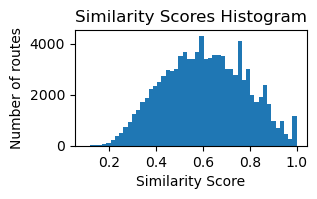

In [9]:
# plot a histogram to show the distribution of the similarity scores between 0 and 1
values = np.array([i['score'] for i in org_scores])
plt.figure(figsize=(3, 1.5))
plt.hist(values, density=False, bins=50)
plt.ylabel('Number of routes')
plt.xlabel('Similarity Score')
plt.title('Similarity Scores Histogram')
plt.show()

**View the similarity scores for each driver separately**

In [10]:
### ORIGINAL STANDARDROUTES
# dictionary to store the mean similarity score for each driver (given all original standardroutes)
mean_org_scores_d = {}

# loop to get for each driver the actual routes computed with the original standardroutes and compute the mean similarity
for driver in drivers:

    # extract the driver's similarity scores of all the similarity scores computed before and take the mean
    mean = np.mean([i['score'] for i in org_scores if i['driver'] == driver])

    # append the driver id and mean score to the dictionary
    mean_org_scores_d.update({driver: mean})

### RECOMMENDED STANDARDROUTES
# dictionary to store the mean similarity score for each driver (given all recommended standardroutes)
mean_rec_scores_d = {}

# loop to get for each driver the actual routes computed with all recommended standardroutes and compute the mean similarity
for driver in drivers:

    # extract the driver's similarity scores of all the similarity scores computed before and take the mean
    mean = np.mean([i['score'] for i in rec_scores if i['driver'] == driver])

    # append the driver id and mean score to the dictionary
    mean_rec_scores_d.update({driver: mean})

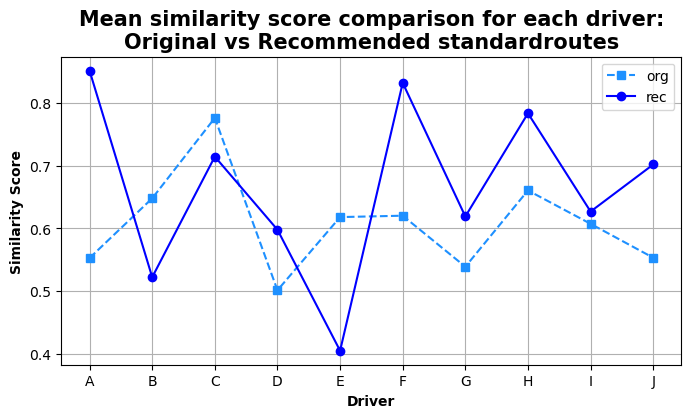

In [11]:
# funciton to compare similarity scores for each driver
def fun_plot_scores(scores1, scores2, color1, color2, label1, label2, title):

    # create plot to compare similarity scores
    plt.figure(figsize=(8, 4))
    plt.plot(drivers, scores1.values(), marker='s', linestyle='--', color=color1, label=label1)
    plt.plot(drivers, scores2.values(), marker='o', linestyle='-', color=color2, label=label2)

    # set title, edit axis and add legend
    plt.title(title, fontsize=15, fontweight='bold')
    plt.ylabel('Similarity Score', fontsize=10, fontweight='bold')
    plt.xlabel('Driver', fontsize=10, fontweight='bold')
    plt.legend(loc='upper right')

    # grid lines
    plt.grid(True)

    return plt.show()

# execute function to compare the scores of original and recommended standardroutes
fun_plot_scores(scores1=mean_org_scores_d, scores2=mean_rec_scores_d,
                color1='dodgerblue', color2='blue',
                label1='org', label2='rec',
                title='Mean similarity score comparison for each driver:\nOriginal vs Recommended standardroutes')

In [12]:
# # check if any similarity is zero and view the combinations with less than 0.3 similarity score
# print('Is any similarity score zero:', np.any(values == 0))
# #display([i for i in values if i < 0.3][:10])

# # view the combination with the lowest similarity score
# idx_min = np.argmin(values)
# lowest_score = [i for i in org_scores if i['id'] == str('a' + str(idx_min+1))][0]
# standardroute = [i for i in org_standardroutes if i['id'] == lowest_score['sroute']][0]
# actual_route = [i for i in org_actual_routes if i['id'] == lowest_score['id']][0]
# print("\nLowest score by standardroute '{}' and actual route '{}' from driver '{}' with {} similarity.".format(standardroute['id'], actual_route['id'], actual_route['driver'], np.round(np.min(values), 4)))

# # view details
# fun_similarity_score(route1=standardroute, route2=actual_route, prints=True)

**View the similarity scores for each standardroute separately**


In [13]:
# # plot a histogram for every standardroute to show the distribution
# standardroute_ids = [i['id'] for i in org_standardroutes]

# # define subplot grid
# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 12))
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Similarity Score distribution per standardroute", fontsize=18, y=0.95)

# # loop through standardroutes and axes
# for id, ax in zip(standardroute_ids, axs.ravel()):
#     values = [i['score'] for i in org_scores if i['sroute'] == id]
#     ax.hist(values, density=False, bins=50)
#     ax.set_ylabel('Number of routes')
#     ax.set_xlabel('Similarity Score')
#     ax.set_title(f'Standardroute {id}')

# plt.show()

**View the similarity scores for each driver separately**

In [14]:
# # plot a histogram for every driver to show the distribution
# drivers = np.sort(list(set([i['driver'] for i in org_actual_routes])))

# # define subplot grid
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(22, 6))
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Similarity Score distribution per driver", fontsize=18, y=0.95)

# # loop through drivers and axes
# for driver, ax in zip(drivers, axs.ravel()):
#     values = [i['score'] for i in org_scores if i['driver'] == driver]
#     ax.hist(values, density=False, bins=50)
#     ax.set_ylabel('Number of routes')
#     ax.set_xlabel('Similarity Score')
#     ax.set_title(f'driver {driver}')

# plt.show()

# **Evaluation - Problem 2**

### **Check whether the attributes of each driver are visible in the recommended standardroutes**

In [15]:
# load file with recommended standardroutes of the drivers
rec_drivers = fun_load_file(path='../../results', name=str('driver' + appendix + '.json'))
#display(rec_drivers)

In [16]:
# view the characters of the drivers
display(df_drivers_attributes)
print('Liked cites:', driver_cities_likes)
print('Liked cites:', driver_cities_dislikes)
print('Liked/disliked products:', driver_products)

,likes short routes,likes long routes,likes a city,dislikes a city,likes few products,likes many products,likes a product,dislikes a product,likes high quantities,likes low quantities
driver_A,Yes,-,-,-,-,-,-,-,-,Yes
driver_B,-,Yes,-,-,-,Yes,-,-,-,-
driver_C,-,-,Yes,-,-,-,-,Yes,-,-
driver_D,-,-,Yes,Yes,-,-,-,-,-,Yes
driver_E,-,Yes,-,-,Yes,-,-,-,-,-
driver_F,Yes,-,-,-,-,Yes,-,-,-,-
driver_G,Yes,-,-,-,-,-,Yes,-,-,-
driver_H,-,-,-,Yes,-,Yes,-,Yes,-,-
driver_I,Yes,-,-,-,-,-,-,-,Yes,-
driver_J,-,-,-,-,-,-,Yes,-,-,Yes


Liked cites: {'driver_C': ['Trento', 'Padova'], 'driver_D': ['Rome', 'Trento']}
Liked cites: {'driver_D': ['Milano', 'Palermo', 'Lecce'], 'driver_H': ['Lecce', 'Palermo']}
Liked/disliked products: {'driver_C': ['Water'], 'driver_G': ['Beer', 'Cheese'], 'driver_H': ['Milk', 'Water'], 'driver_J': ['Chocolate', 'Honey']}


### **Compare Similarity Scores**

**Create new actual routes for each driver with only his 5 recommended standardroutes and compute the mean similarity scores**

In [17]:
# define how many actual routes should be created for each of the 5 standardroutes for each driver
jobs_per_route = 100

# calculate the amount of actual routes per driver and in total
number_of_actual_routes = jobs_per_route * 5 #5 recommended standardroutes for each driver
print('Number of actual routes per driver: {}'.format(number_of_actual_routes))
print('Number of actual routes in total: {}'.format(number_of_actual_routes*len(drivers)))

Number of actual routes per driver: 500
Number of actual routes in total: 5000


In [18]:
# dictionary to store the mean similarity score for each driver (given only the 5 recommended standardroutes)
mean_rec5_scores_d = {}

# loop to create for each driver new actual routes with its 5 recommended standardroutes and compute the mean similarity
for driver in tqdm(drivers):
    
    # select the ids of the 5 recommended standardroutes for the driver
    id_rec5_sr = [rec['routes'] for rec in rec_drivers if rec['driver'] == driver][0]
    #print(id_rec5_sr)
    
    # extract the routes with the ids out of all original standardroutes
    rec5_standardroutes = []
    for rec in id_rec5_sr:
        rec5_standardroutes.append([sr for sr in org_standardroutes if sr['id'] == rec][0])
    #for i in rec5_standardroutes: show_route(i)
    
    # create the actual routes for the driver
    actual_routes_driver = fun_aroutes(input_sr=rec5_standardroutes, driver_given=driver, prints=False, bar=False)

    # compute the similarity scores of all the just generated actual routes of the driver with its corresponding 5 recommended standardroutes for the driver
    scores_driver = compute_similarites(input_sr=rec5_standardroutes, input_ar=actual_routes_driver, prints=False, bar=False)

    # compute the mean similarity score of all scores for the driver
    mean = np.mean([i['score'] for i in scores_driver])

    # append the driver id and mean score to the dictionary
    mean_rec5_scores_d.update({driver: mean})

 30%|███       | 3/10 [00:02<00:06,  1.15it/s]

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


**Plot results**

Mean similarity score all standardroutes: 0.6075
Mean similarity score recommended 5 standardroutes: 0.6371


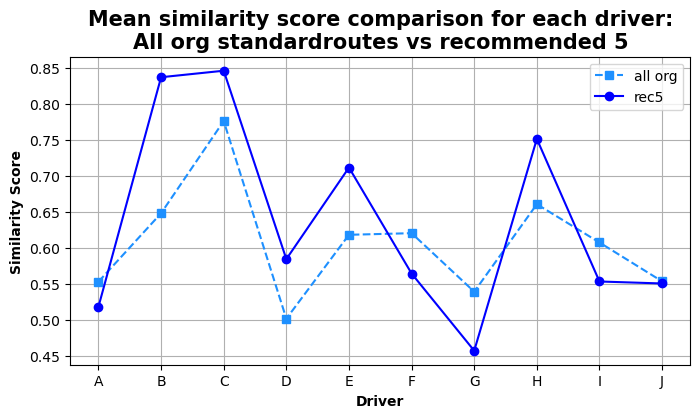

In [19]:
# compare mean similarity scores
print('Mean similarity score all standardroutes:', np.round(np.mean(list(mean_org_scores_d.values())), 4))
print('Mean similarity score recommended 5 standardroutes:', np.round(np.mean(list(mean_rec5_scores_d.values())), 4))

# use previous defined plot funciton to compare the mean scores for the drivers
fun_plot_scores(scores1=mean_org_scores_d, scores2=mean_rec5_scores_d, 
                color1='dodgerblue', color2='blue',
                label1='all org', label2='rec5',
                title='Mean similarity score comparison for each driver:\nAll org standardroutes vs recommended 5')

# **Evaluation - Problem 3**

In [20]:
# load file with perfect routes for each driver
perfectRoute = fun_load_file(path='../../results', name=str('perfectRoute' + appendix + '.json'))

# append an id to each perfect route
for idx, route in enumerate(perfectRoute):
    route.update({'id':idx+1,
                  'sroute': idx+1})

# view perfect routes
#for i in perfectRoute: show_route(i)

In [21]:
# define how many actual routes should be created for each of the 5 standardroutes for each driver
jobs_per_route = 100

# calculate the amount of actual routes per driver and in total
number_of_actual_routes = jobs_per_route #only one perfect route for each driver
print('Number of actual routes per driver: {}'.format(number_of_actual_routes))
print('Number of actual routes in total: {}'.format(number_of_actual_routes*len(drivers)))

Number of actual routes per driver: 100
Number of actual routes in total: 1000


**Create new actual routes for each driver with his perfect route and compute the mean similarity scores**

In [22]:
# dictionary to store the mean similarity score for each driver
perfect_scores_d = {}

# loop to create for each driver new actual routes with its perfect standardroute and compute the similarity
for driver in tqdm(drivers):
    
    # select the driver's perfect route
    perfect_standardroute = [i for i in perfectRoute if i['driver'] == driver]
    #print(perfect_standardroute)
    
    # create the actual routes for the driver
    actual_routes_driver = fun_aroutes(input_sr=perfect_standardroute, driver_given=driver, prints=False, bar=False)

    # compute the similarity scores of all the just generated actual routes of the driver with its corresponding 5 recommended standardroutes for the driver
    scores_driver = compute_similarites(input_sr=perfect_standardroute, input_ar=actual_routes_driver, prints=False, bar=False)

    # compute the mean similarity score of all scores for the driver
    mean = np.mean([i['score'] for i in scores_driver])

    # append the driver id and mean score to the dictionary
    perfect_scores_d.update({driver: mean})

100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


Mean similarity score all standardroutes: 0.6075
Mean similarity score perfect standardroute: 0.9527


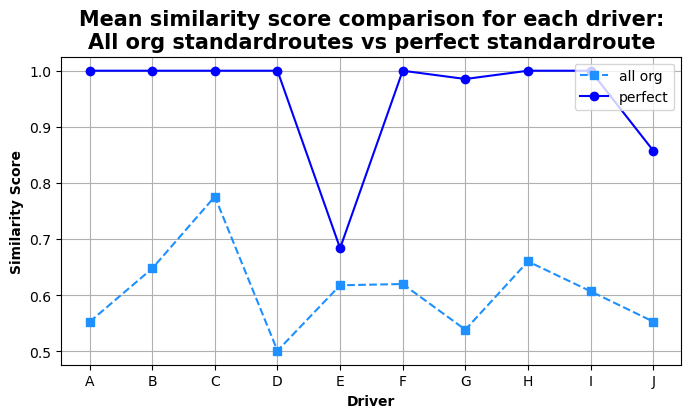

In [23]:
# compare mean similarity scores
print('Mean similarity score all standardroutes:', np.round(np.mean(list(mean_org_scores_d.values())), 4))
print('Mean similarity score perfect standardroute:', np.round(np.mean(list(perfect_scores_d.values())), 4))

# use previous defined plot funciton to compare the mean scores for the drivers
fun_plot_scores(scores1=mean_org_scores_d, scores2=perfect_scores_d, 
                color1='dodgerblue', color2='blue',
                label1='all org', label2='perfect',
                title='Mean similarity score comparison for each driver:\nAll org standardroutes vs perfect standardroute')